# Image classification using CNNs and ResNets

## Exploring the data

In [2]:
import os
import torch
import tarfile
from torchvision.datasets.utils import download_url

In [4]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, './data')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [5]:
# Extract from archive
with tarfile.open('./data/cifar10.tgz','r:gz') as tar:
    tar.extractall(path='./data')

In [7]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir+"/train")
print(classes)

['test', 'train']
['truck', 'airplane', 'bird', 'ship', 'cat', 'automobile', 'frog', 'deer', 'horse', 'dog']


In [8]:
airplane_files = os.listdir(data_dir+'/train/airplane')
print('# of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

# of training examples for airplanes: 5000
['2357.png', '3617.png', '1118.png', '1867.png', '4109.png']


In [9]:
ship_test_files = os.listdir(data_dir+'/test/ship')
print('# of test examples for ship:', len(ship_test_files))
print(ship_test_files[:5])

# of test examples for ship: 1000
['0243.png', '0642.png', '0215.png', '0062.png', '0620.png']


In [10]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [13]:
dataset = ImageFolder(data_dir+'/train',transform=ToTensor())

In [14]:
dataset

Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./data/cifar10/train
    StandardTransform
Transform: ToTensor()

In [15]:
img, label = dataset[0]
print(img.shape,label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [16]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [17]:
import matplotlib.pyplot as plt

def show_example(img,label):
    print('Label:',dataset.classes[label],'('+str(label)+')')
    plt.imshow(img.permute(1,2,0))

Label: airplane (0)


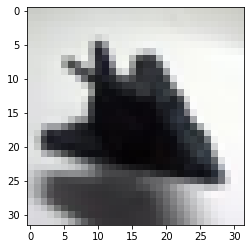

In [18]:
show_example(*dataset[0])

Label: airplane (0)


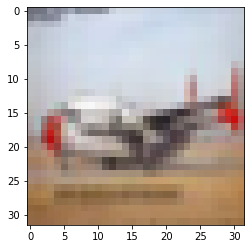

In [23]:
show_example(*dataset[1099])